In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import os
from PIL import Image

In [2]:
df = pd.read_csv("aptos2019-blindness-detection/train.csv")
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


In [3]:
class_names = df['diagnosis'].unique()
class_names

array([2, 4, 1, 0, 3], dtype=int64)

In [4]:
id_codes = df['id_code'].tolist()
random_image_id = random.choice(id_codes)

diagnosis_mapping = {
    0: "No DR",
    1: "Mild",
    2: "Moderate",
    3: "Severe",
    4: "Proliferative DR"
}

id_codes = df['id_code'].tolist()

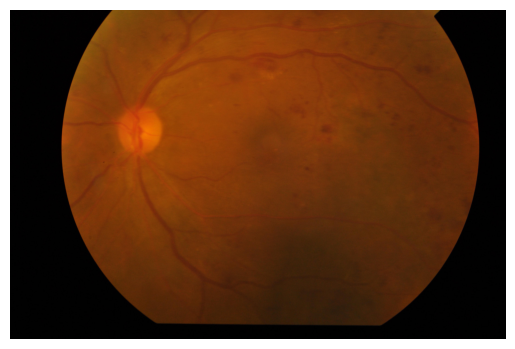

The diagnosis for 0ca0aee4d57e is: Moderate


In [5]:
random_image_id = random.choice(id_codes)

image_path = os.path.join('aptos2019-blindness-detection/train_images', f'{random_image_id}.png')

if os.path.exists(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off') 
    plt.show()

    diagnosis_code = df[df['id_code'] == random_image_id]['diagnosis'].values[0]
    
    diagnosis = diagnosis_mapping[diagnosis_code]
    
    print(f"The diagnosis for {random_image_id} is: {diagnosis}")
else:
    print(f"Image {random_image_id}.png not found in the test_images directory.")

# EDA

In [6]:
print(f"Dataset Shape: {df.shape}")
print(f"Dataset Columns: {df.columns.tolist()}")
print(df.info())
print(df.describe())

Dataset Shape: (3662, 2)
Dataset Columns: ['id_code', 'diagnosis']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3662 entries, 0 to 3661
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id_code    3662 non-null   object
 1   diagnosis  3662 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 57.3+ KB
None
         diagnosis
count  3662.000000
mean      1.126980
std       1.298409
min       0.000000
25%       0.000000
50%       1.000000
75%       2.000000
max       4.000000


In [7]:
print(f"Missing Values:\n{df.isnull().sum()}")

Missing Values:
id_code      0
diagnosis    0
dtype: int64


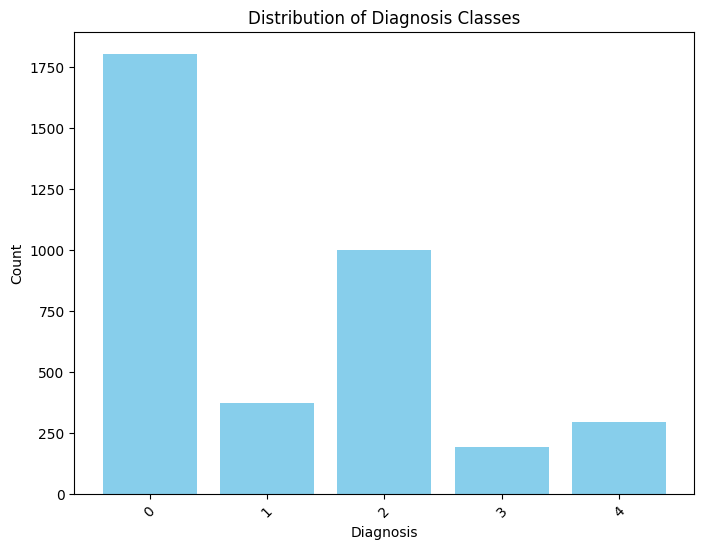

In [8]:
class_counts = df['diagnosis'].value_counts()
plt.figure(figsize=(8, 6))
plt.bar(class_counts.index, class_counts.values, color='skyblue')
plt.title('Distribution of Diagnosis Classes')
plt.xlabel('Diagnosis')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
diagnosis_percentage = df['diagnosis'].value_counts(normalize=True) * 100
print(f"Diagnosis Distribution (%):\n{diagnosis_percentage}")

Diagnosis Distribution (%):
diagnosis
0    49.290005
2    27.280175
1    10.103768
4     8.055707
3     5.270344
Name: proportion, dtype: float64


# Data Preprocessing

In [10]:
from sklearn.model_selection import train_test_split
from PIL import Image

In [11]:
def load_and_preprocess_image(image_id, folder):
    image_path = os.path.join(f"aptos2019-blindness-detection/{folder}/", f'{image_id}.png')
    if os.path.exists(image_path):
        img = Image.open(image_path).convert('RGB')  
        img = img.resize(image_size)  
        img_array = np.array(img) / 255.0  
        return img_array
    else:
        print(f"Image {image_id}.png not found.")
        return None

In [12]:
image_size = (128, 128)  
batch_size = 32          
num_classes = 5 

In [13]:
images = []
labels = []

for index, row in df.iterrows():
    image_id = row['id_code']
    diagnosis = row['diagnosis']
    image = load_and_preprocess_image(image_id, 'train_images')
    
    if image is not None:
        images.append(image)
        labels.append(diagnosis)

images = np.array(images)
labels = np.array(labels)

In [14]:
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

# Densenet201

In [23]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

num_classes = 5  

base_model = DenseNet201(include_top=False, weights=None, input_shape=(128, 128, 3))
base_model.trainable = False

model = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),
    base_model,
    layers.GlobalAveragePooling2D(name="global_average_pooling"),  
    layers.Dense(1024, activation='relu'), 
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax', name='output_layer')  
])

model.compile(optimizer=Adam(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           5,125 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,294,213 (77.42 MB)

 Trainable params: 1,972,229 (7.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [24]:
batch_size = 32
epochs = 20
input_shape = (128, 128, 3)  

history = model.fit(
    X_train,       
    y_train,       
    validation_data=(X_val, y_val),  
    epochs=epochs,      
    batch_size=batch_size  
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 93s 856ms/step - accuracy: 0.4548 - loss: 1.3527 - val_accuracy: 0.4925 - val_loss: 1.2661
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 72s 787ms/step - accuracy: 0.5099 - loss: 1.2547 - val_accuracy: 0.5239 - val_loss: 1.2377
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 65s 711ms/step - accuracy: 0.4995 - loss: 1.2266 - val_accuracy: 0.4925 - val_loss: 1.2001
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 66s 723ms/step - accuracy: 0.5117 - loss: 1.2046 - val_accuracy: 0.5894 - val_loss: 1.2035
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 69s 748ms/step - accuracy: 0.5238 - loss: 1.1998 - val_accuracy: 0.5102 - val_loss: 1.1333
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 68s 736ms/step - accuracy: 0.5595 - loss: 1.1467 - val_accuracy: 0.5880 - val_loss: 1.0960
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 106s 1s/step - accuracy: 0.5753 - loss: 1.1369 - val_accuracy: 0.5771 - val_loss: 1.0882
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 598ms/step - accuracy: 0.5510 - loss: 1.1517 - val_accura

In [25]:
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 13s 543ms/step - accuracy: 0.6418 - loss: 1.0403
Validation Loss: 1.0059850215911865
Validation Accuracy: 0.6480218172073364


In [21]:
test = pd.read_csv("aptos2019-blindness-detection/test.csv")
test.head()

,id_code
0,0005cfc8afb6
1,003f0afdcd15
2,006efc72b638
3,00836aaacf06
4,009245722fa4


# Edit 1

In [27]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam

num_classes = 5  

base_model = DenseNet201(include_top=False, weights=None, input_shape=(128, 128, 3))
base_model.trainable = False

edit1 = models.Sequential([
    layers.Input(shape=(128, 128, 3), name="input_layer"),
    base_model,  
    layers.GlobalAveragePooling2D(name="global_average_pooling"),  
    layers.Dense(1024, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(512, activation='relu'),  
    layers.Dropout(0.5),  
    layers.Dense(num_classes, activation='softmax', name='output_layer')  
])

edit1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

edit1.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)             │ (None, 4, 4, 1920)          │      18,321,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling               │ (None, 1920)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1024)                │       1,967,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 5)                   │           2,565 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,816,453 (79.41 MB)

 Trainable params: 2,494,469 (9.52 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [29]:
batch_size = 32
epochs = 20
input_shape = (128, 128, 3)  

history = edit1.fit(
    X_train,       
    y_train,       
    validation_data=(X_val, y_val),  
    epochs=epochs,      
    batch_size=batch_size  
)

Epoch 1/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 98s 939ms/step - accuracy: 0.4665 - loss: 1.3685 - val_accuracy: 0.4925 - val_loss: 1.2899
Epoch 2/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 84s 918ms/step - accuracy: 0.4957 - loss: 1.2811 - val_accuracy: 0.4925 - val_loss: 1.2578
Epoch 3/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 83s 899ms/step - accuracy: 0.5023 - loss: 1.2347 - val_accuracy: 0.4925 - val_loss: 1.1985
Epoch 4/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 81s 882ms/step - accuracy: 0.5116 - loss: 1.1988 - val_accuracy: 0.4939 - val_loss: 1.1638
Epoch 5/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 82s 897ms/step - accuracy: 0.5353 - loss: 1.1800 - val_accuracy: 0.6262 - val_loss: 1.1349
Epoch 6/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5418 - loss: 1.1567 - val_accuracy: 0.6112 - val_loss: 1.1058
Epoch 7/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 78s 847ms/step - accuracy: 0.5970 - loss: 1.0719 - val_accuracy: 0.5321 - val_loss: 1.1212
Epoch 8/20
92/92 ━━━━━━━━━━━━━━━━━━━━ 79s 864ms/step - accuracy: 0.5828 - loss: 1.0987 - val_accura

In [30]:
val_loss, val_accuracy = edit1.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

23/23 ━━━━━━━━━━━━━━━━━━━━ 16s 706ms/step - accuracy: 0.6658 - loss: 0.9677
Validation Loss: 0.9429416060447693
Validation Accuracy: 0.6780354976654053


# Edit 2